For this notebook, we'll cover uncovering crossings in a clustered time series - like what was discussed in the hard_clustering_cluster_crossings_example Jupyter notebook but from a soft clustering approach (using a simple Gaussian Mixture Model).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

from clustervisualizer.ClusterAnalyzer import ClusterAnalyzer as clust
from clustervisualizer.CrossingAnalyzer import CrossingAnalyzer as cross
from clustervisualizer.examples.simulate_detector import simulate_detector as sim

from sklearn.mixture import GaussianMixture

We'll use the same detector simulator like in the other notebook, but now we'll create a transition region between the two gases. When in this region, the mean and standard deviation of the normal distribution to sample will be derived by taking the *weighted average* of the low and high temperature means and standard deviations.

Let's analyze the simulation of a temperature detector, cluster the temperature measurements, and study the accuracy of the results.

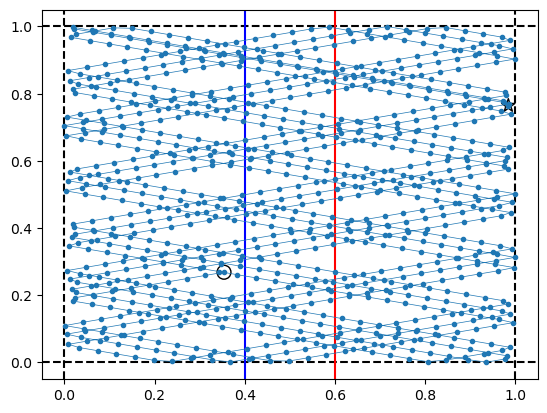

In [2]:
def run_detectors(n, detector_kwargs, plot=None):
    if plot is None: plot = False
    
    # intialize all detectors 
    det_dict = { 'det'+str(i) : sim(**detector_kwargs) for i in range(n) }
    
    df_list = []
    for det_key in det_dict:
        # get detector
        det = det_dict[det_key]
        # run sim and get data
        det.start()
        det_df = det.get_data()
        # add fake time data to each detector
        det_df['time'] = pd.date_range(start='2008-01-01',
                                       freq='1 min',
                                       periods=det_df.shape[0])
        # save detector id and data
        det_df['id'] = det_key
        df_list.append( det_df )
        # if specified, plot trajectory
        if plot: det.plot_trajectory()
        
    return det_dict, pd.concat(df_list)


# set kwargs for detector sim and run
detector_kwargs = {'max_iter':10**3,
                   'temp_boundary':[0.4,0.6]}
detector_dict, data = run_detectors(1, detector_kwargs, plot=True)

The first solid vertical line (blue) shows where the lower temp gas boundary ends and the second solid vertical line (red) shows where the high temp gas begins. The middle area in between is the transition region.

<AxesSubplot: xlabel='x', ylabel='y'>

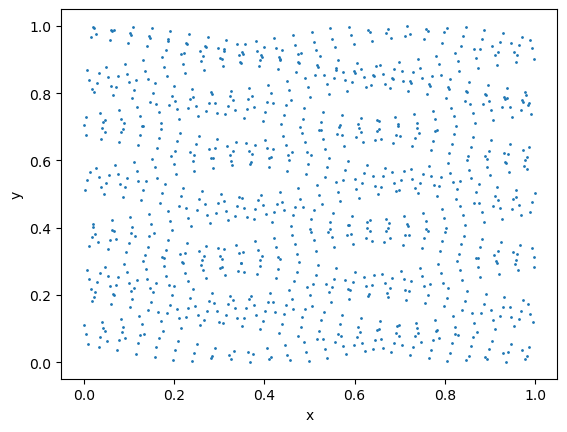

In [3]:
# show raw detector positions
data.plot.scatter('x', 'y', s=1)

Let's cluster the temperature measurements using a gaussian mixture model ...

In [4]:
gm = GaussianMixture(n_components=2, random_state=1).fit( data['temp'].values.reshape(-1,1) )
gm_preds = gm.predict_proba( data['temp'].values.reshape(-1,1) )

... and look at the scatter plot of each cluster probability.

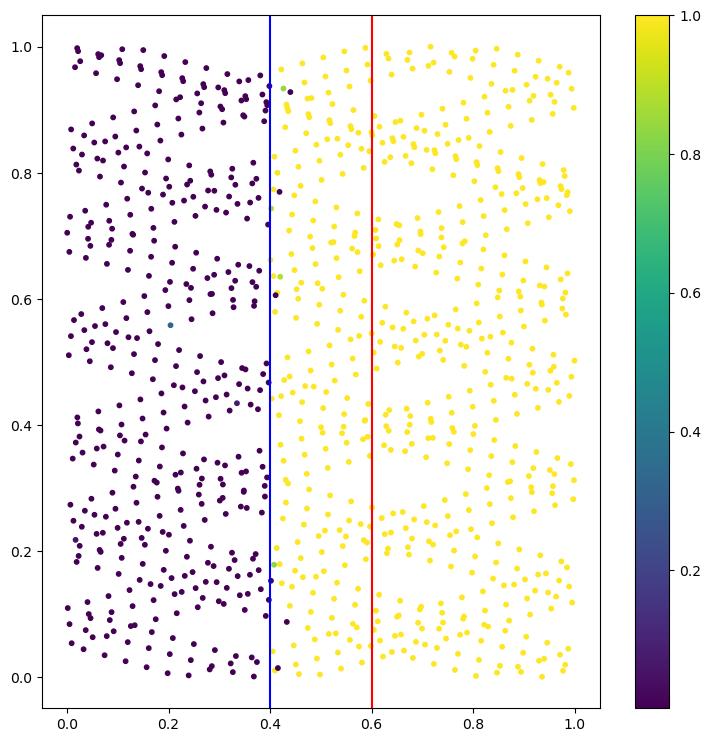

In [5]:
fig, axes = plt.subplots(1,1, figsize=(9,9))
_fig_ref = axes.scatter(data['x'], data['y'], s=10, c=gm_preds[:,0])#, cmap='winter')
axes.axvline(x=0.4, c='blue')
axes.axvline(x=0.6, c='red')
fig.colorbar(_fig_ref, ax=axes)

It seems like the entirety of the transition region is classified as belonging to the high temperature cluster (and given how the data was generated and mixture models work, that makes sense).

Let's also look at the histograms (in log scale) of each cluster probability.

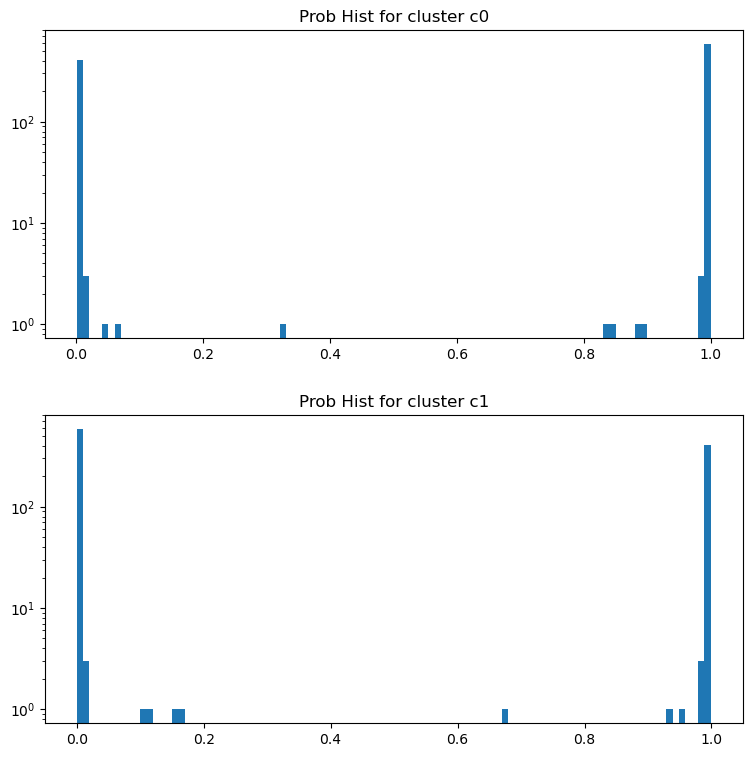

In [6]:
fig, axes = plt.subplots(2,1, figsize=(9,9))
for i in range( len(axes) ):
    axes[i].hist( gm_preds[:,i], bins=100, log=True )
    axes[i].set_title( 'Prob Hist for cluster c'+str(i) )
fig.subplots_adjust(hspace=0.25)

We can create a ClusterAnalyzer object and study the histograms, both in 1d and 2d.

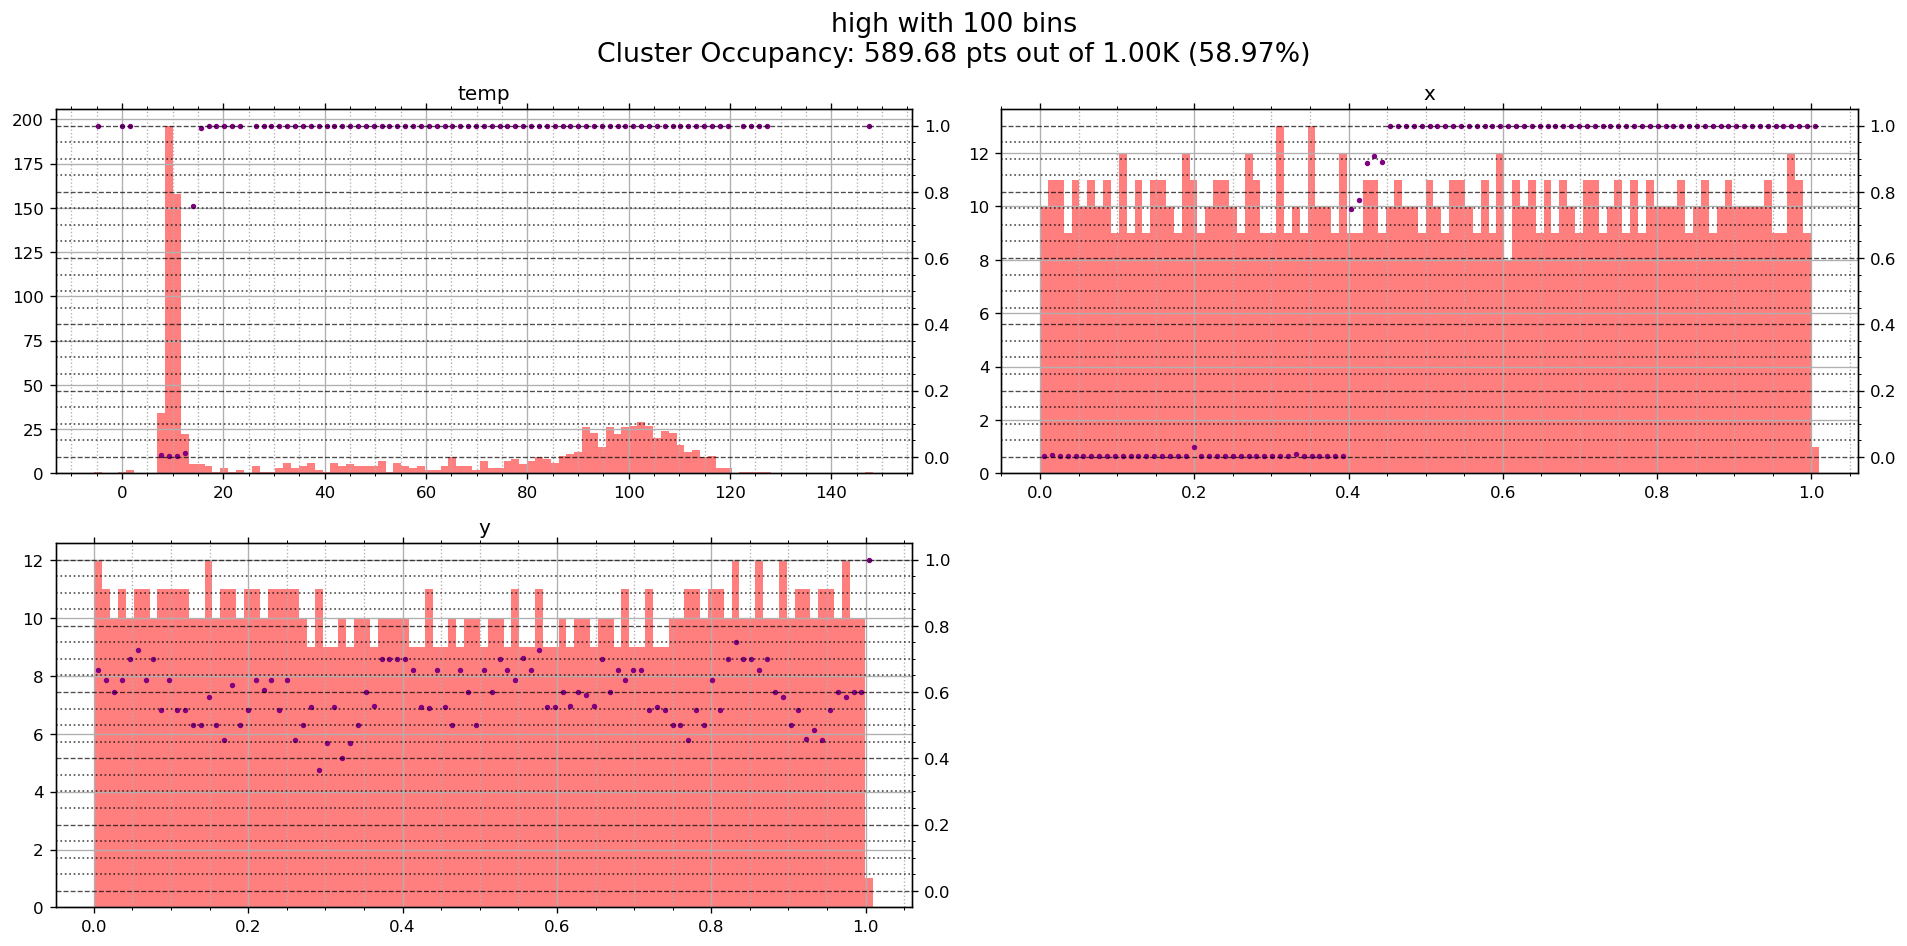

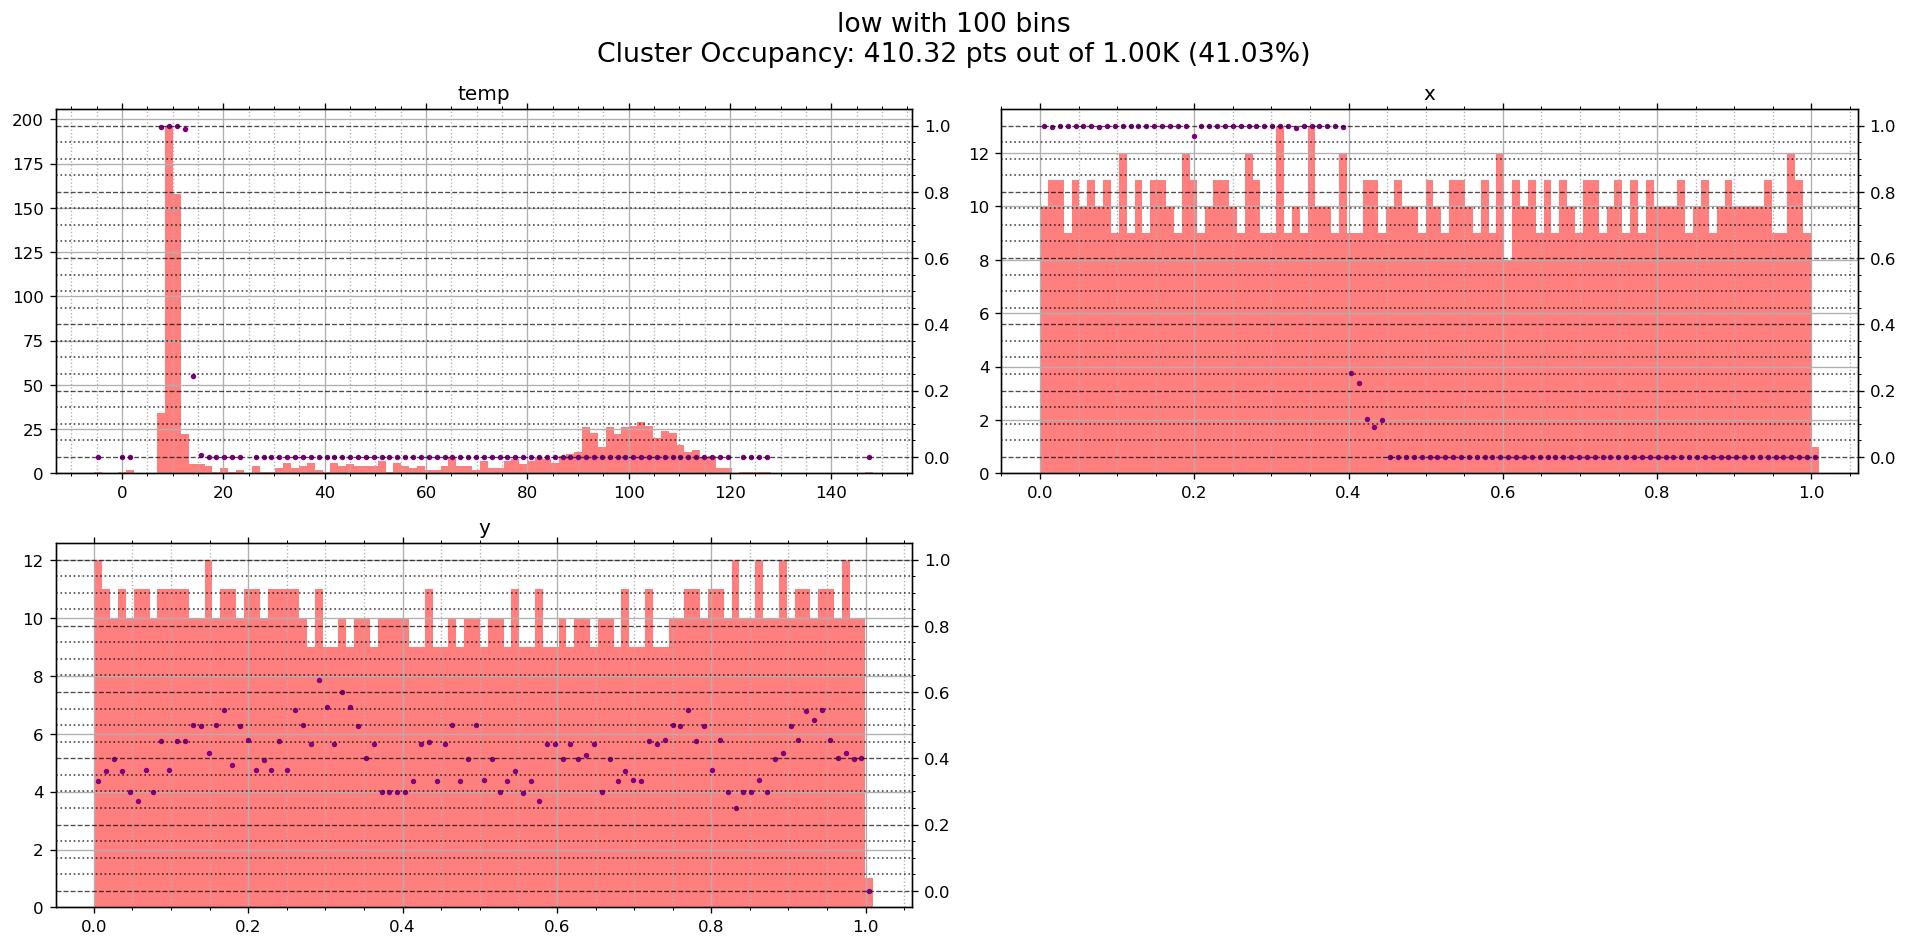

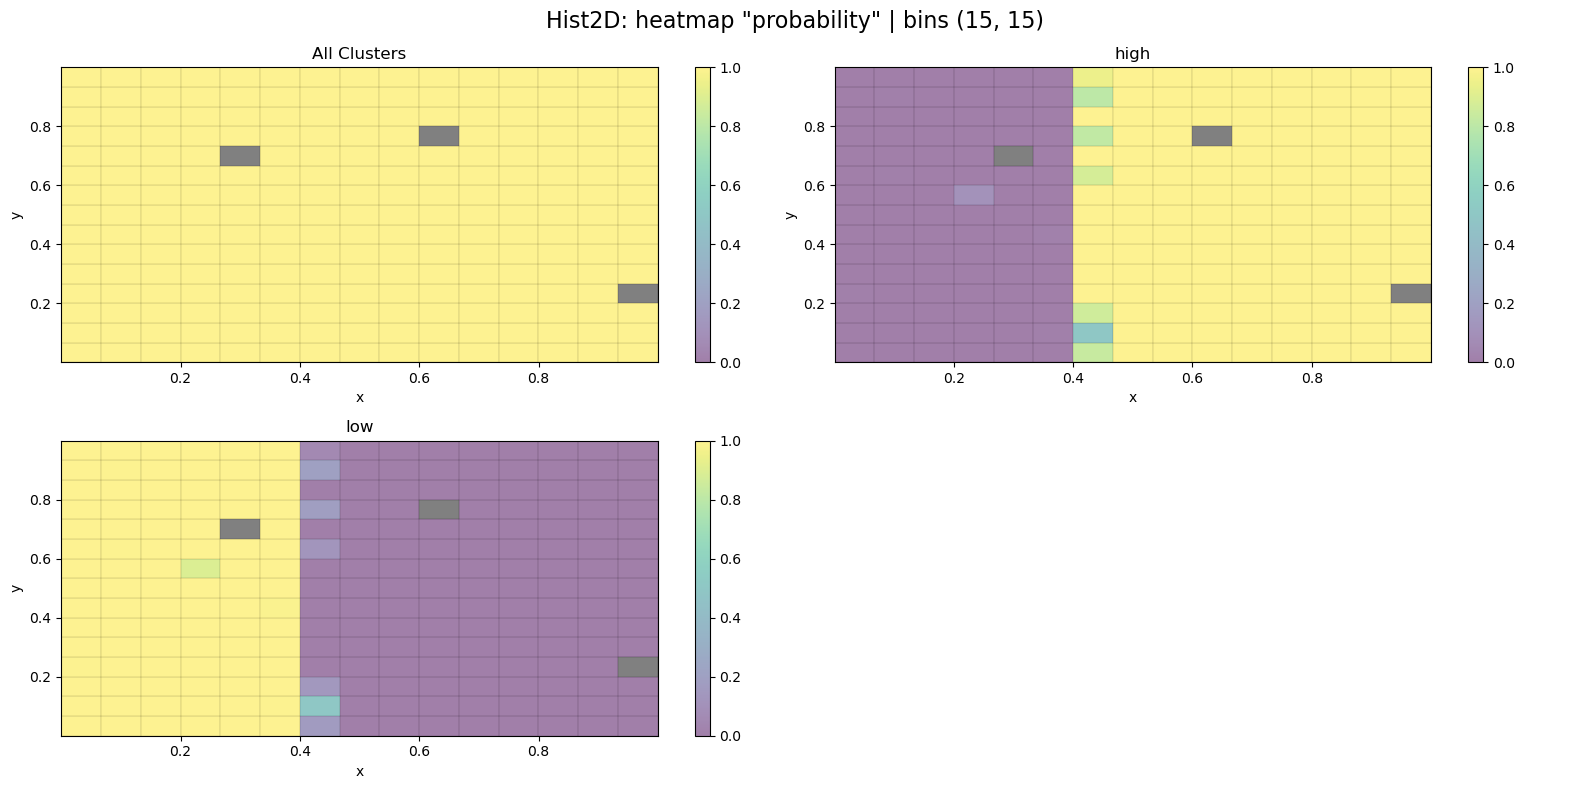

In [7]:
_clust = clust(data, gm_preds,
               name_clusters={'low': ('temp', lambda x: -1*np.mean(x)),
                              'high': 'temp'})
## Create histograms
_clust.hist1d(bins=100,
              hist_vars=['temp','x','y'])
_clust.hist2d(histxy = ('x','y'),
              hist_var = 'probability',
              bins = (15,15))

Now we can begin to compute the resulting crossings. This requires some extra specification in constrast to when doing this with hard clustering, which can be communicated best using a diagram.

    DIAGRAM

    -------
        
    prob-axis
       || * *   * * * * * * * * |       | o o   o o o o o o | 
       || |   *     |           *       o     o   |         o 
       ||-|---------|-----------|-------|---------|---------|- min_prob
       || |         |           | * * o |         |         |
       || |         |           | o o * |         |         |
       || |   o     |           o       *     *   |         * 
       || o o   o o o o o o o o |       | * *   * * * * * * | 
     ==||=|=========|===========|=======|=========|=========|= time-axis
       || X         |           A       B         |         Y
       ||           Q                             W
               * - cluster 1 probability
               o - cluster 2 probability

This is similar to the diagram in the hard_clustering_cluster_crossings_example Notebook, but not probabability of a point belong to a cluster can take any value between 0 and 1 (instead of just 0 *or* 1).

There is one additional argument that need to be mentioned in the context of soft clustering:

    min_prob (float - optional, default 0.8):
           Probability threshold used to determine if a point "belongs" to a cluster or not. This is used to determine
           when the dominant cluster of a point changes so that cluster crossings can be found.

In [8]:
# we set a time step resolution of 1 minute, so let's pick ...
#   (1) 5 minutes for min_crossing_duration
#   (2) 5 minutes for min_beyond_crossing_duration
#   (3) 10 minutes for max_beyond_crossing_duration
cross_dict = _clust.compute_crossings(
                time_var='time',
                min_prob = 0.8,
                min_crossing_duration = pd.Timedelta('1 min'),
                max_crossing_duration = pd.Timedelta('5 min'),
                min_beyond_crossing_duration = pd.Timedelta('5 min'),
                max_beyond_crossing_duration = pd.Timedelta('10 min'),
                min_cluster_frac = 0.8,
                order_matters = False
                                      )

# print out some info about the crossigns
for key in cross_dict:
    num = len( np.unique( cross_dict[key]['crossing_num'] ) )
    print(key,'has',num,'crossings')
    if num > 0:
        print('sample crossings:')
        print( cross_dict[key][:10] )

Computing crossings under constraints:
   None
('low', 'high') has 41 crossings
sample crossings:
          x         y        vx        vy        temp                time  \
0  0.849821  0.802553 -0.041411  0.009514  113.991021 2008-01-01 00:04:00   
1  0.808410  0.812067 -0.041411  0.009514  106.416084 2008-01-01 00:05:00   
2  0.766999  0.821581 -0.041411  0.009514   80.209444 2008-01-01 00:06:00   
3  0.725589  0.831094 -0.041411  0.009514   84.226135 2008-01-01 00:07:00   
4  0.684178  0.840608 -0.041411  0.009514  104.297079 2008-01-01 00:08:00   
5  0.642767  0.850122 -0.041411  0.009514   99.837748 2008-01-01 00:09:00   
6  0.601356  0.859635 -0.041411  0.009514  108.967201 2008-01-01 00:10:00   
7  0.559945  0.869149 -0.041411  0.009514   69.352300 2008-01-01 00:11:00   
8  0.518534  0.878662 -0.041411  0.009514   67.873745 2008-01-01 00:12:00   
9  0.477124  0.888176 -0.041411  0.009514   65.548208 2008-01-01 00:13:00   

     id  crossing_points  crossing_num  low  high  
0 

In [9]:
# determine which was crossings were recorded - either ('high','low') or reverse
# depending on simulator data
name_tuple = ('high','low') if ('high','low') in cross_dict else ('low','high')
cross_names = { name_tuple : 'foo' }

# instantiate
_cross = cross(cross_dict,
               crossing_names=cross_names)

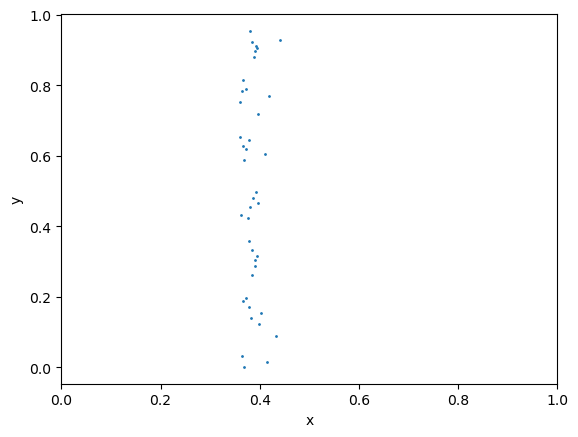

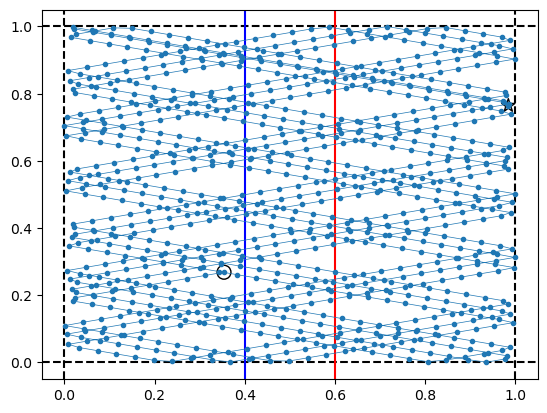

In [16]:
cross_df = _cross.get_crossing_dfs_as_list(
                crossing='foo',
                cluster='low',
                    # which cluster of the crossing should be retrieved
                point_type='immediate',
                    # determines which interval of data to retrieve...
                    #  'immediate' --> (A,B)
                    #  'normal' -----> (Q,W)
                    #  'extended' ---> (X,Y)
                single_df=True
                    # if False, returns all data as a list of dataframes; True concats them
                                            )


# plot the x,y crossing data and detector trajectory side-by-side
ax = cross_df.plot.scatter('x', 'y', s=1)
ax.set_xlim(0,1)
#print(data)
detector_dict['det0'].plot_trajectory()